imports

In [44]:
import shutil
import os
import numpy as np
import zipfile
import pandas as pd
import seaborn as sns
from pyexpat import features
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from sklearn.model_selection import train_test_split



In [45]:
import os
print(os.listdir())


['Feed_Forward_NN.ipynb', 'preprocessing.ipynb', 'selected_randoms-100.zip', 'preprocessed_data.pkl', 'Wavelet.ipynb', 'ID_228_analysis_2002.csv', 'random-data-selection.py', 'RNN-LSTM.ipynb', 'RidgeRegression.ipynb', 'Gauge_attributes.csv']


load data and concatenate regions

In [46]:


zip_path = "selected_randoms-100.zip"

df_list = []

with zipfile.ZipFile(zip_path) as z:
    for file in z.namelist():
        if file.endswith(".csv"):
            temp = pd.read_csv(z.open(file), sep=";")
            temp["location_id"] = int(file.split("_")[-1].replace(".csv", ""))
            df_list.append(temp)

df_merged = pd.concat(df_list, ignore_index=True)

df_merged.head()

,YYYY,MM,DD,DOY,2m_temp_max,2m_temp_mean,2m_temp_min,2m_dp_temp_max,2m_dp_temp_mean,2m_dp_temp_min,...,surf_net_solar_rad_max,surf_net_solar_rad_mean,surf_net_therm_rad_max,surf_net_therm_rad_mean,surf_press,total_et,prec,volsw_123,volsw_4,location_id
0,1981,1,1,1,2.5,-0.1,-2.9,-0.5,-3.4,-6.5,...,126,20,60,39,94590.0,0.48,8.10,0.40,0.4,310
1,1981,1,2,2,0.8,-1.1,-2.7,-1.3,-3.6,-5.8,...,72,14,42,25,94662.0,0.36,7.99,0.39,0.4,310
2,1981,1,3,3,5.3,3.4,1.1,2.1,0.4,-0.9,...,126,22,51,22,93411.0,0.15,13.91,0.40,0.4,310
3,1981,1,4,4,3.0,1.2,-1.0,1.9,-0.5,-2.3,...,145,29,70,43,93118.0,0.32,6.30,0.41,0.4,310
4,1981,1,5,5,-1.1,-3.0,-4.6,-2.7,-5.9,-7.9,...,75,16,67,43,93685.0,0.63,8.96,0.41,0.4,310


null value analysis

In [47]:
print(df_merged.isnull().sum())


YYYY                       0
MM                         0
DD                         0
DOY                        0
2m_temp_max                0
2m_temp_mean               0
2m_temp_min                0
2m_dp_temp_max             0
2m_dp_temp_mean            0
2m_dp_temp_min             0
10m_wind_u                 0
10m_wind_v                 0
fcst_alb                   0
lai_high_veg               0
lai_low_veg                0
swe                        0
surf_net_solar_rad_max     0
surf_net_solar_rad_mean    0
surf_net_therm_rad_max     0
surf_net_therm_rad_mean    0
surf_press                 0
total_et                   0
prec                       0
volsw_123                  0
volsw_4                    0
location_id                0
dtype: int64


The meteorological time series have no gaps.

data analysis distribution correlations and so on tables and graphs

order date according to date not location and split data into target variable and features

In [48]:
#TODO delete dates too ?
df_merged = df_merged.rename(columns={'YYYY':'year', 'MM':'month', 'DD':'day'})
df_merged['date'] = pd.to_datetime(
    df_merged['year'].astype(str) + '-' +
    df_merged['month'].astype(str) + '-' +
    df_merged['day'].astype(str)
)
df_merged = df_merged.set_index('date')
df_merged = df_merged.sort_values(['date', 'location_id']).reset_index(drop=True)

target= df_merged['prec']
features= df_merged.drop(columns=['prec'])
features = features.reset_index()

features = features.drop(columns=["year", "month", "day", "DOY", "index"])
target = target.reset_index(drop=True)
df_merged = df_merged.reset_index()


features



,2m_temp_max,2m_temp_mean,2m_temp_min,2m_dp_temp_max,2m_dp_temp_mean,2m_dp_temp_min,10m_wind_u,10m_wind_v,fcst_alb,lai_high_veg,...,swe,surf_net_solar_rad_max,surf_net_solar_rad_mean,surf_net_therm_rad_max,surf_net_therm_rad_mean,surf_press,total_et,volsw_123,volsw_4,location_id
0,0.1,-3.3,-6.7,-1.8,-5.6,-10.5,1.8,1.0,0.45,1.9,...,152.53,100,15,55,23,92059.0,-0.07,0.34,0.40,15
1,0.1,-3.4,-7.9,-1.7,-6.0,-11.8,1.4,0.9,0.49,2.2,...,148.31,97,13,55,18,93487.0,-0.11,0.34,0.40,17
2,-1.2,-3.7,-6.5,-2.7,-5.7,-9.5,2.6,1.0,0.45,2.6,...,172.78,90,15,53,26,89574.0,-0.03,0.34,0.40,26
3,-5.8,-8.5,-11.9,-7.1,-11.1,-15.8,1.1,0.4,0.44,2.5,...,276.36,91,15,39,17,82382.0,-0.12,0.33,0.39,33
4,-1.6,-3.8,-6.2,-3.6,-6.4,-10.0,3.6,0.7,0.48,2.3,...,161.26,97,15,61,30,88076.0,0.11,0.34,0.40,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1424395,2.3,-0.4,-3.3,-0.9,-3.9,-7.5,1.2,0.3,0.26,1.2,...,9.21,163,28,69,39,96189.0,0.19,0.39,0.36,833
1424396,3.5,0.4,-3.0,-0.3,-3.0,-6.1,1.9,-0.3,0.21,1.9,...,4.03,143,28,68,41,97659.0,0.10,0.37,0.32,844
1424397,3.6,0.1,-3.3,-0.5,-3.3,-6.3,0.9,-0.3,0.14,1.3,...,2.02,206,36,76,45,97541.0,0.05,0.38,0.34,845
1424398,3.7,0.4,-2.9,-0.3,-3.0,-6.0,1.8,-0.3,0.20,1.9,...,3.65,149,29,67,42,97843.0,0.10,0.36,0.32,848


In [49]:
constant_cols = [col for col in features.columns if features[col].nunique() == 1]
print("Dropping constant columns:", constant_cols)
features = features.drop(columns=constant_cols)



Dropping constant columns: []


In [50]:
numeric_cols = features.select_dtypes(include=[np.number]).columns.tolist()
print("Numeric columns to scale:")
print(numeric_cols)

Numeric columns to scale:
['2m_temp_max', '2m_temp_mean', '2m_temp_min', '2m_dp_temp_max', '2m_dp_temp_mean', '2m_dp_temp_min', '10m_wind_u', '10m_wind_v', 'fcst_alb', 'lai_high_veg', 'lai_low_veg', 'swe', 'surf_net_solar_rad_max', 'surf_net_solar_rad_mean', 'surf_net_therm_rad_max', 'surf_net_therm_rad_mean', 'surf_press', 'total_et', 'volsw_123', 'volsw_4', 'location_id']


Data Exploration

Correlation between target variable and each feature variable

In [51]:
correlations = features.corrwith(target).sort_values(ascending=False)
print(correlations)

10m_wind_u                 0.223898
lai_high_veg               0.174248
2m_dp_temp_mean            0.157797
2m_dp_temp_min             0.156410
2m_dp_temp_max             0.142924
2m_temp_min                0.121645
volsw_123                  0.055586
2m_temp_mean               0.043607
volsw_4                    0.033374
lai_low_veg                0.011233
total_et                   0.010198
fcst_alb                   0.000188
swe                       -0.001380
2m_temp_max               -0.029726
location_id               -0.087631
10m_wind_v                -0.088442
surf_press                -0.118341
surf_net_solar_rad_mean   -0.205079
surf_net_solar_rad_max    -0.220782
surf_net_therm_rad_max    -0.486688
surf_net_therm_rad_mean   -0.504787
dtype: float64


correlation plotted

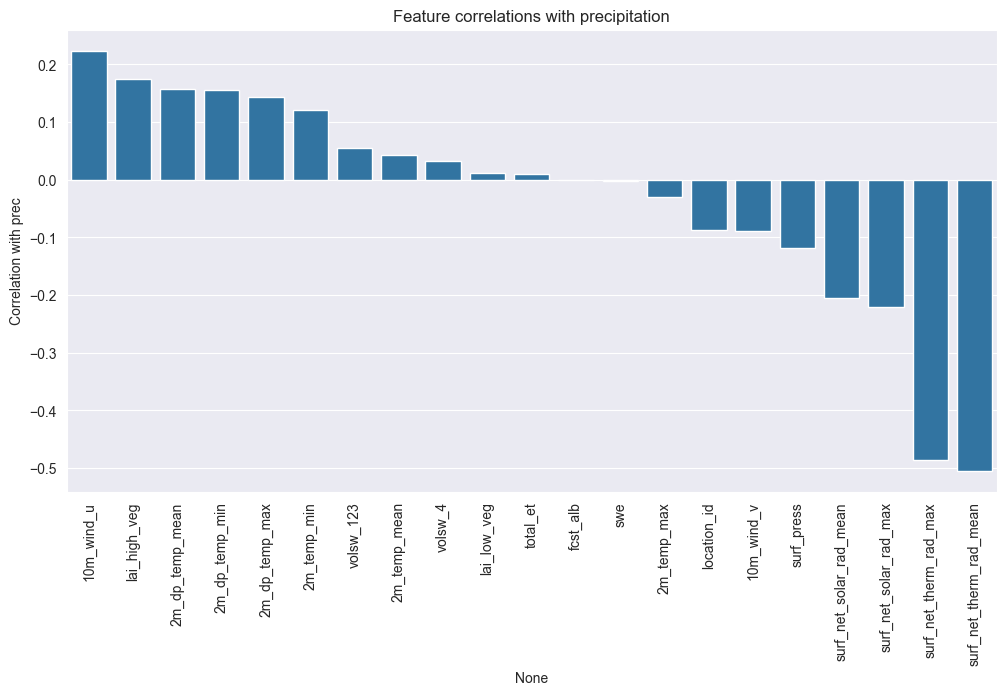

In [52]:
plt.figure(figsize=(12,6))
sns.barplot(x=correlations.index, y=correlations.values)
plt.xticks(rotation=90)
plt.ylabel("Correlation with prec")
plt.title("Feature correlations with precipitation")
plt.show()

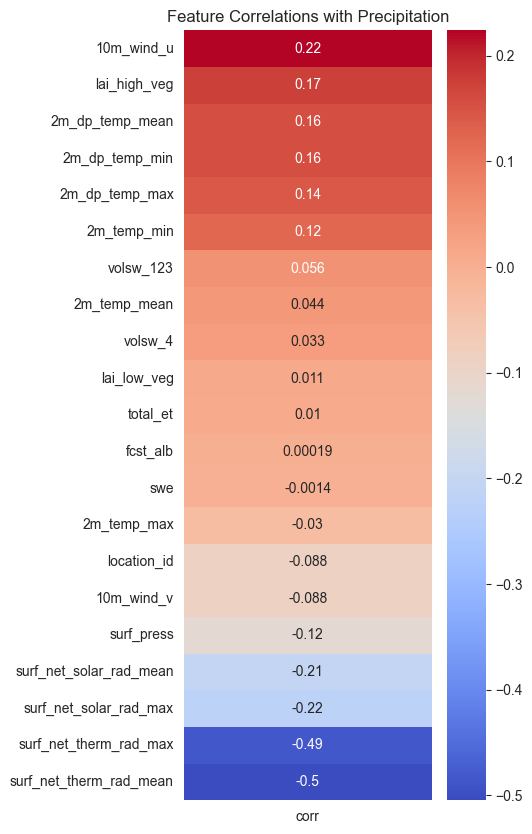

In [53]:
plt.figure(figsize=(4,10))
sns.heatmap(correlations.to_frame(name="corr"), annot=True, cmap="coolwarm")
plt.title("Feature Correlations with Precipitation")
plt.show()


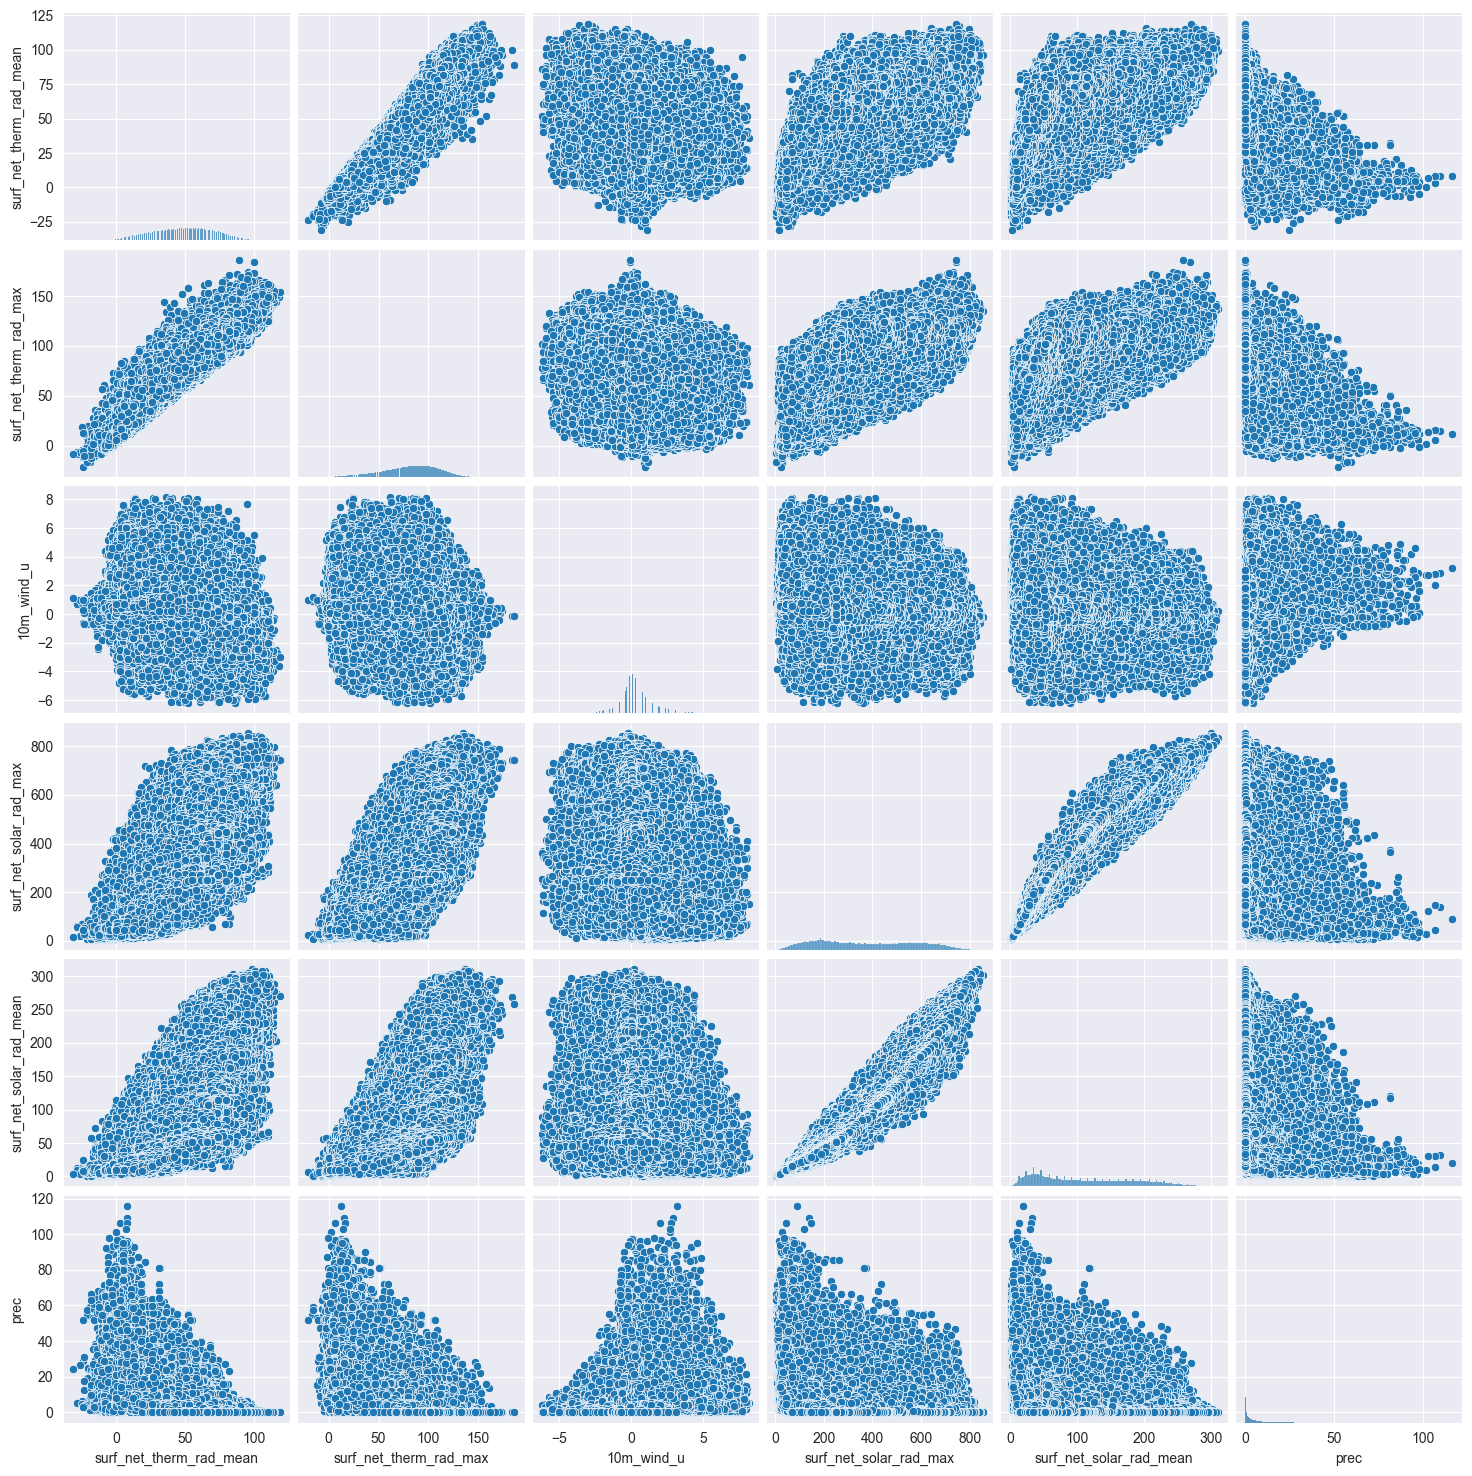

In [54]:
subset = features[correlations.abs().sort_values(ascending=False).index[:5]].copy()
subset["prec"] = target.values
sns.pairplot(subset)
plt.show()

data preprocessing impute missing values normalize and so on

split data

In [55]:


X = features
y = target

n = len(df_merged)

train_size = int(n * 0.7)
val_size   = int(n * 0.15)
# test size = rest

X = features
y = target.reset_index(drop=True)

dates = df_merged.index.values
test_dates = dates[train_size + val_size:]

X_train = X.iloc[:train_size].copy()
y_train = y.iloc[:train_size].copy()

X_val = X.iloc[train_size:train_size + val_size].copy()
y_val = y.iloc[train_size:train_size + val_size].copy()

X_test = X.iloc[train_size + val_size:].copy()
y_test = y.iloc[train_size + val_size:].copy()


7 day moving AVERAGE

In [56]:
n = 7  # 7-day moving average

df_ma = df_merged.copy()
df_ma[f"prec_MA{n}"] = df_ma["prec"].rolling(n).mean()

# Drop NaNs introduced by rolling
df_ma = df_ma.dropna()

X = df_ma[[f"prec_MA{n}"]]
y = df_ma["prec"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=False, test_size=0.2
)

from sklearn.metrics import mean_squared_error

y_pred = X_test[f"prec_MA{n}"]  # MA is already the prediction

print("MSE:", mean_squared_error(y_test, y_pred))

MSE: 8.480075215585623


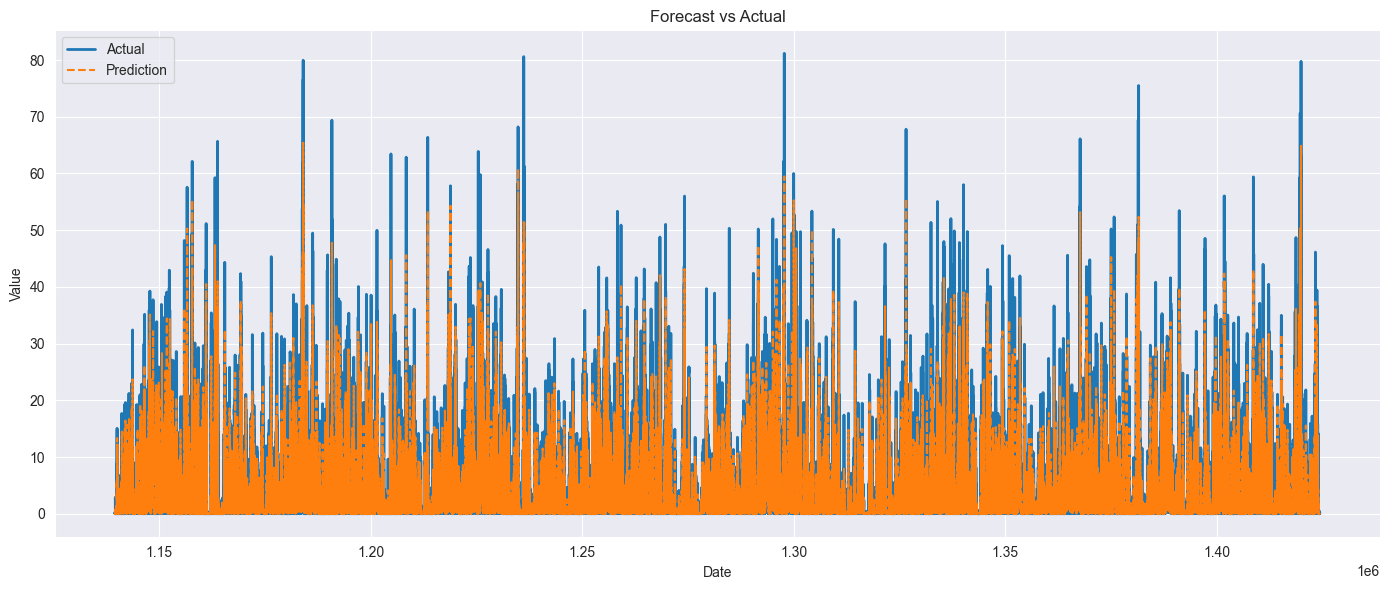

In [58]:
# Extract matching date index for plotting
dates = df_merged.index

split_point = int(len(df_merged) * 0.8)  # same as your test_size=0.2
dates_train = dates[:split_point]
dates_test  = dates[split_point:]


import matplotlib.pyplot as plt

# Extract matching dates directly from y_test index
dates_test = y_test.index

plt.figure(figsize=(14, 6))
plt.plot(dates_test, y_test, label="Actual", linewidth=2)
plt.plot(dates_test, y_pred, label="Prediction", linestyle="--")
plt.title("Forecast vs Actual")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



scale data using min max scaler

In [41]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_val[numeric_cols]   = scaler.transform(X_val[numeric_cols])
X_test[numeric_cols]  = scaler.transform(X_test[numeric_cols])


scaler_y = MinMaxScaler()

y_train_log = np.log1p(y_train.values.reshape(-1,1))
y_val_log   = np.log1p(y_val.values.reshape(-1,1))
y_test_log  = np.log1p(y_test.values.reshape(-1,1))

y_train = scaler_y.fit_transform(y_train_log)
y_val   = scaler_y.transform(y_val_log)
y_test  = scaler_y.transform(y_test_log)



KeyError: "None of [Index(['2m_temp_max', '2m_temp_mean', '2m_temp_min', '2m_dp_temp_max',\n       '2m_dp_temp_mean', '2m_dp_temp_min', '10m_wind_u', '10m_wind_v',\n       'fcst_alb', 'lai_high_veg', 'lai_low_veg', 'swe',\n       'surf_net_solar_rad_max', 'surf_net_solar_rad_mean',\n       'surf_net_therm_rad_max', 'surf_net_therm_rad_mean', 'surf_press',\n       'total_et', 'volsw_123', 'volsw_4', 'location_id'],\n      dtype='object')] are in the [columns]"

#TODO discussing data quality, why knowing the data quality is important and why data engineering is important

7 day moving average (MA)

In [26]:
n = 7  # 7-day moving average

df_ma = df_merged.copy()
df_ma[f"prec_MA{n}"] = df_ma["prec"].rolling(n).mean()

# Drop NaNs introduced by rolling
df_ma = df_ma.dropna()

X = df_ma[[f"prec_MA{n}"]]
y = df_ma["prec"]


In [27]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, shuffle=False, test_size=0.2
)

from sklearn.metrics import mean_squared_error

y_pred = X_test[f"prec_MA{n}"]  # MA is already the prediction

print("MSE:", mean_squared_error(y_test, y_pred))


MSE: 8.480075215585623
